# The Daubechies D4 Wavelet Tranform

##### All functions and variables declaration

In [50]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from time import time

def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return csr_matrix(matrix_coeffs)
    # return csr_matrix(np.round(matrix_coeffs, 8))
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])


##### Daubechies Functions

In [51]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(daubechies_coeffs.dot(row))
    result_V = daubechies_coeffs.dot(result_H)

    if scale == 1:
        normalized = result_V.copy()
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}")
    return np.ones_like(image), np.ones_like(image)


def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width):
    new_transform = transform_result.copy()
    image = []
    
    if scale == 1:
        daubechies_coeffs_transpose = daubechies_coeffs.T
        
        result_H = daubechies_coeffs_transpose.dot(transform_result)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_img = width // (2 ** scale) * 2
        aP = new_transform[:tam_img, :tam_img]
        daubechies_coeffs_transpose = np.transpose(function_daubechies_coeffs(aP))
        
        result_H = daubechies_coeffs_transpose.dot(aP)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)

        new_transform[:len(image), :len(image)] = image

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(new_transform),new_transform,scale-1,new_transform.shape[0])

In [52]:
def zeros(image, scale):
    tam_img = image.shape[0] // (2 ** scale)
    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    return image

##### Checking Orthonormality

In [53]:
def verificar_ortonormalidad(v1, v2):
    if len(v1) != len(v2):
        print("The vectors are not similar, they are not orthonormal")

    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    if np.isclose(dot_product, 0) and np.isclose(norm_v1, 1) and np.isclose(norm_v2, 1):
        print(f"The vectors are orthonormal, the dot product is: {dot_product} and the norm of each vector is {norm_v1, norm_v2} respectively")
    else:
        print("The vectors are similar but they are not orthonormal")
    
verificar_ortonormalidad(h_coeffs, g_coeffs)

The vectors are orthonormal, the dot product is: 0.0 and the norm of each vector is (0.9999999999999998, 0.9999999999999998) respectively


## NUMERIC EXAMPLE

In [54]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
# print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
# print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")

In [55]:
aP,cH,cV,cD = split_matrix(example)
scale = 1
dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,scale,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,scale,dwt.shape[0])

print(f"Original Matrix:\n {example}")
print(f"\nDirect daubechies Wavelet Transform\n {np.round(dwt,0)}")
print(f"\nInverse daubechies Wavelet Transform\n {np.round((idwt),0)}")

Original Matrix:
 [[12 30  7 30  2 51 33 10]
 [18 10 30 23  7 32 35 40]
 [42 47 27 24 46  6  5 24]
 [ 1 33 42  0 28 14  0 51]
 [12 18 11 14 14 51 14 12]
 [44 36 49  7 38 40 24 39]
 [17  4 14 31 21 48 23 15]
 [12 23 25 39 24 37 11 36]]

Direct daubechies Wavelet Transform
 [[ 40.  43.  55.  56.  -5. -26.   8.  -3.]
 [ 58.  40.  32.  42.  17.  18. -33. -21.]
 [ 61.  35.  75.  51.  18.  -7. -12.   8.]
 [ 30.  54.  66.  41. -12. -20. -15.  -8.]
 [ 26.  14.  -2. -12. -17.  25.   1.  20.]
 [-28. -16.  10. -22. -20. -23.   9.  -1.]
 [-20.  -5.   7.  -8.  -8.  -6.  12.   9.]
 [  7. -11.  10. -18. -17. -13.  13.  -6.]]

Inverse daubechies Wavelet Transform
 [[12. 30.  7. 30.  2. 51. 33. 10.]
 [18. 10. 30. 23.  7. 32. 35. 40.]
 [42. 47. 27. 24. 46.  6.  5. 24.]
 [ 1. 33. 42.  0. 28. 14.  0. 51.]
 [12. 18. 11. 14. 14. 51. 14. 12.]
 [44. 36. 49.  7. 38. 40. 24. 39.]
 [17.  4. 14. 31. 21. 48. 23. 15.]
 [12. 23. 25. 39. 24. 37. 11. 36.]]


## IMAGES EXAMPLES

In [56]:
photo = 'imagen.jpg'

0.6118764877319336


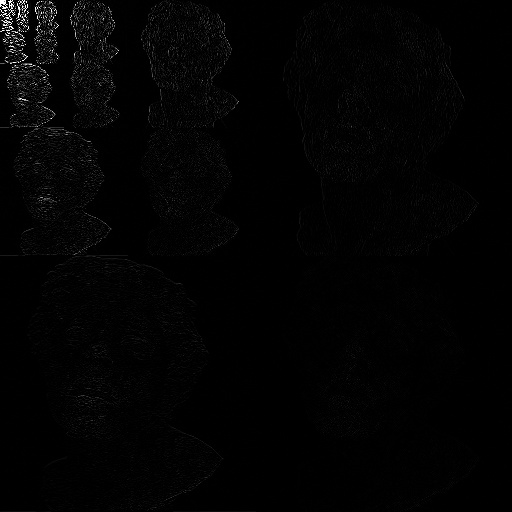

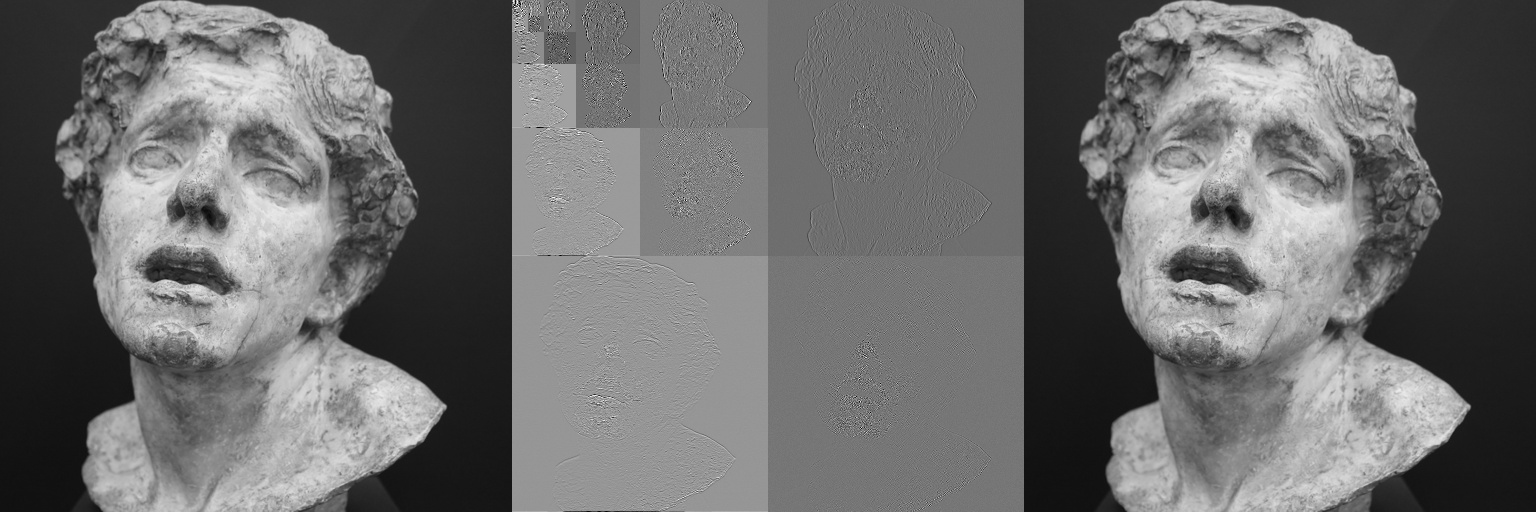

In [57]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 7, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
# result_img = zeros(result_img, scale)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)
final_time = time()


execution_time = final_time - initial_time
print(execution_time)
imshow(result_img)
imshow(np.concatenate((array_photo, normalized, reconstructed), axis = 1))
